# Homework 3 solution
- INFO 4871 / 5871
- Spring 2019
- _Juan Vargas-Murillo_

# NOTE: LKPy 0.6.0

To do this homework, you will need to upgrade to LKPy version 0.6.0. I generally try to avoid requiring software changes in the middle of the quarter, but in this case, the benefits are (I believe) worth the hassle. Using `conda` to update should be sufficient. If you have trouble with the update not being detected (as I did on my Mac), you may need to use the `pip`+github method described at https://github.com/lenskit/lkpy.

## Objective (all students)
The object of this assignment is to gain familiarity with algorithm evaluation in LKPy. You will do this by implementing a simple hybrid recommender system and evaluating it relative to its components. I have provided the following:
- An outline of the WeightedHybrid class. 
- A useful utility function my_clone in hwk3_util.py
- A simple test case for the WeightedHybrid class
- The definition of two knn algorithms UserUserFallback and ItemItemFallback in Fallbacks.py. These are also hybrids in which Bias algorithm is used to predict if not enough neighbors are found. 

You will first implement the WeightedHybrid. It computes a numerical prediction from its component algorithms and then combines these in a weighted average. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Predictor, Recommender
from lenskit.algorithms.basic import UnratedItemCandidateSelector
from lenskit.metrics.predict import rmse

In [3]:
%load_ext autoreload
%aimport Weighted_Hybrid
%aimport hwk3_util
%autoreload 2

from Weighted_Hybrid import WeightedHybrid
from hwk3_util import my_clone
from Fallbacks import UserUserFallback, ItemItemFallback

## 1. Implement Weighted Hybrid

In [4]:
import unittest
from test_weighted import test_WeightedHybrid

%aimport test_weighted

In [5]:
suite = unittest.TestLoader().loadTestsFromTestCase(test_weighted.test_WeightedHybrid)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_more_components (test_weighted.test_WeightedHybrid) ... ok
test_normalize_weights (test_weighted.test_WeightedHybrid) ... ok
test_predict (test_weighted.test_WeightedHybrid) ... ok

----------------------------------------------------------------------
Ran 3 tests in 6.781s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Evaluation with RMSE

### Load ratings data

In [7]:
ratings = pd.read_csv('ratings.csv', encoding='Latin 1')
ratings.columns = ['user', 'item', 'rating', 'timestamp']

### Create algorithms
Neighbors = 20, Min neighbors = 5

In [8]:
user_comp = UserUserFallback(20, min_nbrs=5)
item_comp = ItemItemFallback(20, min_nbrs=5)

### Weighted hybrid 
UserUser 0.8 ItemItem 0.2

In [9]:
weighted_hybrid = WeightedHybrid([user_comp, item_comp], [0.8,0.2])

### A helper function for doing the evaluation
Makes repeated calls to `batch.predict` easier to perform.

(Adapted from LKPy "Getting started" documentation.)

In [10]:
def eval_preds(aname, fold, algo, train, test):
    fittable = my_clone(algo)
    fittable.fit(train)
    
    preds = batch.predict(fittable, test)
    preds['Algorithm'] = aname
    preds['Fold'] = fold
    return preds

### Perform 5-fold cross-validation
Note that all the happens here is that predictions are generated. Evaluation is later.

In [11]:
np.random.seed(20190303)

all_preds = []
fold = 0
# HOMEWORK 3 TODO
# Implement 5-fold cross-validation with user-based splitting
# Call eval_preds for each algorithm, each fold
# Results should be appended to all_preds
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    print("Completed fold {}".format(fold))
    all_preds.append(eval_preds('UserComponent', fold, user_comp, train, test))
    all_preds.append(eval_preds('ItemComponent', fold, item_comp, train, test))
    all_preds.append(eval_preds('WeightedHybrid', fold, weighted_hybrid, train, test))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


### Combine all results into one data frame

In [12]:
all_preds = pd.concat(all_preds, ignore_index=True)
all_preds.head()

,user,item,rating,prediction,Algorithm,Fold
0,975,112852,4.0,3.930192,UserComponent,0
1,975,4011,4.0,4.083562,UserComponent,0
2,975,1732,4.5,4.312282,UserComponent,0
3,975,5952,3.5,4.038854,UserComponent,0
4,975,91658,3.5,3.986704,UserComponent,0


### Compute results
- Create an RMSE for each fold of each algorithm
- Compute the mean and standard deviation of over the folds for each algorithm

No loops. 2-3 or three lines of code. `groupby`, `apply`, and `agg` are your friends. 

In [41]:
# Compute RMSE for each fold of each algorithm
A = all_preds.groupby(['Algorithm', 'Fold']).apply(lambda df: rmse(df.rating, df.prediction)) # .reset_index()
# A.columns = ['Algorithm', 'Fold', 'RMSE']
A

Algorithm       Fold
ItemComponent   0       0.757571
                1       0.743245
                2       0.738638
                3       0.803013
                4       0.728331
UserComponent   0       0.793968
                1       0.777079
                2       0.770060
                3       0.831445
                4       0.760025
WeightedHybrid  0       0.779125
                1       0.762325
                2       0.756490
                3       0.818690
                4       0.745567
dtype: float64

In [78]:
# Compute the mean and standard deviation over the folds of each algorithm
B = A.groupby(['Algorithm']).agg([np.mean, np.std])

### Plot the experimental results
Bar plot with error bars. Don't forget to label the y axis.

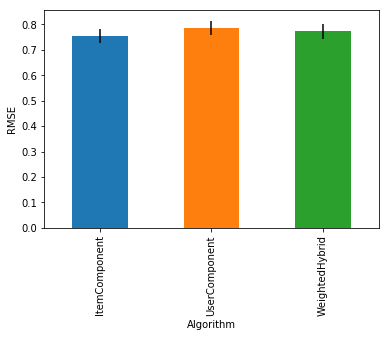

In [79]:
ax = means.plot.bar(x=B.index, y=B['mean'], yerr=B['std'])

plt.ylabel('RMSE')

plt.show()

## Evaluation with recall / precision

### Helper function
Repeated calls to `batch.recommend`. Generate 10 recommendations.

In [80]:
def eval_recs(aname, fold, algo, train, test):
    fittable = my_clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 10)
    # add the algorithm
    recs['Algorithm'] = aname
    recs['Fold'] = fold
    return recs


### Perform 5-fold cross-validation

In [81]:
np.random.seed(20190302)

all_recs = []
test_data = []
fold = 0
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    # HOMEWORK 3 TODO
    # Implement 5-fold cross-validation with user-based splitting
    # Call eval_recs for each algorithm, each fold
    # Results should be appended to all_recs
    # Test data should be a list
    test_data.append(test)
    all_recs.append(eval_recs('UserUser', fold, user_comp, train, test))
    all_recs.append(eval_recs('ItemItem', fold, item_comp, train, test))
    all_recs.append(eval_recs('WeightHybrid', fold, weighted_hybrid, train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


### Combine results into one data frame

In [82]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm,Fold
0,296,4.708202,359,1,UserUser,0
1,7361,4.632040,359,2,UserUser,0
2,589,4.626236,359,3,UserUser,0
3,4973,4.620123,359,4,UserUser,0
4,1193,4.590232,359,5,UserUser,0


### Combine test data into a data frame
Needed by the list-oriented evaluation metrics

In [83]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,359,4144,3.0
1,359,3061,4.5
2,359,800,4.0
3,359,8985,4.0
4,359,48043,4.0


### Computing recall and precision

This step is a bit difficult, and requires an understanding of how `RecListAnalysis` works. So, I supplied the first part of the cell. 

- Create the `RecListAnalysis` object
- Compute the list metrics for each user
- Average the users in each fold for each algorithm
- Compute mean and standard deviation for the algorithm over the folds.

In [104]:
rla = topn.RecListAnalysis()

In [105]:
rla.add_metric(topn.precision)
rla.add_metric(topn.recall)

# results = rla.compute(all_recs, test_data)
# results.head()

byuser_results = all_recs.groupby(['Algorithm','Fold']).apply(lambda df: rla.compute(df, test_data))
byuser_results.head()

precision    recall
Algorithm Fold user Algorithm Fold                     
ItemItem  0    359  ItemItem  0           0.2  0.011976
               1015 ItemItem  0           0.2  0.035714
               1387 ItemItem  0           0.0  0.000000
               2702 ItemItem  0           0.1  0.013889
               4483 ItemItem  0           0.1  0.012658

### Show data frame with evaluation results

In [116]:
eval_fold_mean = byuser_results.groupby(['Algorithm', 'Fold']).mean()
eval_algo = eval_fold_mean.groupby(['Algorithm']).agg([np.mean, np.std])
eval_algo

precision              recall          
                  mean       std      mean       std
Algorithm                                           
ItemItem      0.117996  0.010482  0.023114  0.004377
UserUser      0.165808  0.014868  0.029228  0.003639
WeightHybrid  0.170554  0.013584  0.030523  0.004012

In [122]:
algos = [i for i in eval_algo.index]
algos

['ItemItem', 'UserUser', 'WeightHybrid']

In [123]:
p_means = [p for p in eval_algo['precision']['mean']]
p_means

[0.11799569834655199, 0.16580790428821085, 0.17055383788143577]

In [124]:
p_std = [s for s in eval_algo['precision']['std']]

In [125]:
p_std

[0.010481844296579888, 0.014868269292138053, 0.0135835672585339]

### Bar plot of precision
Similar to above with error bars.

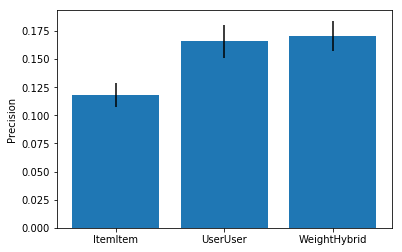

In [130]:
plt.bar(algos, p_means, yerr=p_std)
plt.ylabel('Precision')

plt.show()

### Bar plot of recall
As above

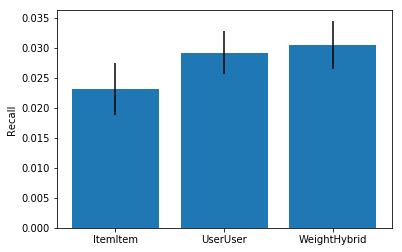

In [131]:
plt.bar(algos, [m for m in eval_algo['recall']['mean']], yerr=[s for s in eval_algo['recall']['std']])
plt.ylabel('Recall')

plt.show()

### (Optional) Scatter plot of recall / precision
See example

## INFO 5871 only
In this section, you will attempt to use linear regression to learn optimal weights for the hybrid. The process is as follows:

- Extract one of the five partitions from the cross-validation iterator. This will be used to learn the weights and then not used for evaluation.
- Train the user-based and item-based algorithms on this partition.
- Use `batch.predict` to compute predictions over the test data.
- Construct a linear regression (`sklearn.linear_model` with `fit_intercept` equal to `False`) with the real test set ratings as the predicted variable and the predictions of the two algorithms as the independent variables.
- Use the coefficients learned by this process to construct a new hybrid.
- Use the remaining four folds of the data to do an evaluation, collecting both prediction values and recommendation lists.
- Following the same methodology as above, produce plots (with error bars) of RMSE and nDCG.
- Don't forget to answer the question at the end.

In [ ]:
from sklearn.linear_model import LinearRegression

### Get one partition for training weights

### Train and predict components on first partition

### Create numpy arrays of predictions and actual ratings

### Run linear regression
fit_intercept = False

### Print regression coefficients

### Create hybrid with regression coefficients as weights

### Run experiment
Do both prediction and recommendation experiments

### Compute RMSE results
Average over the four folds

### Display RMSE bar plot with error bars

### Compute nDCG
Average the users over each fold, then average the folds

### Display nDCG bar plot with error bars

### Question:
The optimization procedue produces a hybrid that has a lower RMSE than either component. But that hybrid does not have the highest nDCG. Why did this happen? What must be true about the distribution of errors such that this hybrid does not produce the best ranking?